In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def load_datasets(parquets_folder,load_test=False):    
    
    path= parquets_folder+'/'
    
    filenames = ['hospital_train_data.parquet','hospital_val_data.parquet','hospital_test_data.parquet']
    
    
    for file in filenames:
        if not os.path.isfile(path+file):
            print(file, 'not available in the specified folder')
        else:
            if '_train_' in file and not load_test:
                print('Loading dataset: ',file)
                train_data = pd.read_parquet(path+file)
            elif '_val_' in file and not load_test:
                print('Loading dataset: ',file)
                val_data = pd.read_parquet(path+file)
            elif '_test_' in file and load_test:
                print('Loading dataset: ',file)
                test_data = pd.read_parquet(path+file)
        
    return (train_data,val_data) if not load_test else test_data
        
                    

In [3]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/A-Machine-Learning-Approach-for-Prediction-of-Hospital-Bed-Availability/

/Users/josefinadallavia/Documents/MIM/Tesis/A-Machine-Learning-Approach-for-Prediction-of-Hospital-Bed-Availability


In [4]:
train_set, val_set = load_datasets('data/hospital_dataset')

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet


In [5]:
pd.options.display.max_columns = None

In [6]:
train_set['admission_weekday'] = pd.to_datetime(train_set['admission_date']).dt.weekday.astype('str')
train_set['date_weekday'] = pd.to_datetime(train_set['date']).dt.weekday.astype('str')

In [7]:
val_set['admission_weekday'] = pd.to_datetime(val_set['admission_date']).dt.weekday.astype('str')
val_set['date_weekday'] = pd.to_datetime(val_set['date']).dt.weekday.astype('str')

In [8]:
categorical = []
numerical = []
for col in train_set:
    if train_set[col].dtype == 'object':
        if train_set[col].nunique() < 10:
            categorical.append(col)
    elif train_set[col].dtype in ['float', 'int'] and col != 'discharge':
        numerical.append(col)

In [9]:
categorical

['gender',
 'entity_group',
 'origin',
 'isolation',
 'ARM_TEP',
 'CEC_TEP',
 'request_sector',
 'admission_weekday',
 'date_weekday']

In [10]:
numerical

['hosp_day_number',
 'images_count',
 'images_cumulative',
 'images_emergencies',
 'images_requester_roles_count',
 'images_requesters_count',
 'images_study_types_count',
 'labos_count',
 'labos_cumulative',
 'labos_emergencies',
 'labos_requester_roles_count',
 'labos_requesters_count',
 'labos_set_count',
 'labos_set_cumulative',
 'sectors_count',
 'sectors_last_stay',
 'surgeries_count',
 'surgeries_cumulative',
 'surgeries_post_surgery_duration',
 'surgeries_pre_surgery_duration',
 'surgeries_prep_duration',
 'surgeries_services_count',
 'surgeries_surgery_delay',
 'surgeries_surgery_duration',
 'surgeries_types_count',
 'emergency_service',
 'new_born_weight',
 'new_born_gestation_age',
 'PIM2TEP',
 'high_risk_TEP',
 'low_risk_TEP',
 'patient_age']

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on categorical columns in the data
    """
    def __init__(self, keys):
        self.keys = keys

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.keys].astype(str)
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [13]:
from sklearn.pipeline import Pipeline

In [14]:
categories = Pipeline([
                ('selector', CategoricalSelector(keys=categorical)),
                ('binarizer', OneHotEncoder())
            ])

In [15]:
from sklearn.preprocessing import StandardScaler

numbers =  Pipeline([
                ('selector', NumberSelector(key='hosp_day_number')),
                ('standard', StandardScaler())
            ])

In [16]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion([('categories', categories), 
                      ('numerical', numbers)])

In [17]:
feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(train_set.fillna(0))

<319150x47 sparse matrix of type '<class 'numpy.float64'>'
	with 3191500 stored elements in Compressed Sparse Row format>

In [11]:
import lightgbm as lgb

In [12]:
y_train = train_set['discharge']
y_val = val_set['discharge']

In [13]:
X_train = train_set.drop('discharge',axis=1)
X_val = val_set.drop('discharge',axis=1)

In [14]:
for col in categorical:
    
    X_train[col] = X_train[col].astype('category')
    X_train[col] = pd.Categorical(X_train[col].cat.codes+1)
    
    X_val[col] = X_val[col].astype('category')
    X_val[col] = pd.Categorical(X_val[col].cat.codes+1)

In [23]:
train_data = lgb.Dataset(X_train[categorical+numerical], 
                         label=y_train, 
                         feature_name=categorical+numerical, 
                         categorical_feature=categorical,
                        free_raw_data=False)

In [24]:
validation_data = lgb.Dataset(X_val[categorical+numerical], 
                              label=y_val, 
                              reference=train_data,
                              feature_name=categorical+numerical, 
                              categorical_feature=categorical,
                              free_raw_data=False)

In [25]:
train_data.save_binary('data/hospital_dataset/train.bin')
validation_data.save_binary('data/hospital_dataset/validation.bin')


/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].cat.set_categories(category)


In [49]:
param = {'num_leaves': 31, 'objective': 'binary', 'metric': 'auc','is_unbalance': True}

In [57]:
y_train.value_counts()

0.0    276453
1.0     42697
Name: discharge, dtype: int64

In [61]:
num_round = 100
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.829671
[2]	valid_0's auc: 0.838345
[3]	valid_0's auc: 0.841722
[4]	valid_0's auc: 0.844156
[5]	valid_0's auc: 0.845815
[6]	valid_0's auc: 0.84633
[7]	valid_0's auc: 0.846945
[8]	valid_0's auc: 0.848102
[9]	valid_0's auc: 0.848606
[10]	valid_0's auc: 0.848824
[11]	valid_0's auc: 0.849209
[12]	valid_0's auc: 0.849784
[13]	valid_0's auc: 0.850566
[14]	valid_0's auc: 0.85112
[15]	valid_0's auc: 0.851588
[16]	valid_0's auc: 0.852084
[17]	valid_0's auc: 0.852305
[18]	valid_0's auc: 0.852775
[19]	valid_0's auc: 0.85299
[20]	valid_0's auc: 0.853364
[21]	valid_0's auc: 0.853543
[22]	valid_0's auc: 0.853897
[23]	valid_0's auc: 0.854045
[24]	valid_0's auc: 0.854244
[25]	valid_0's auc: 0.854495
[26]	valid_0's auc: 0.854848
[27]	valid_0's auc: 0.854943
[28]	valid_0's auc: 0.855126
[29]	valid_0's auc: 0.855376
[30]	valid_0's auc: 0.855681
[31]	valid_0's auc: 0.856097
[32]	valid_0's auc: 0.856315
[33]	valid_0's auc: 0.856606
[34]	valid_0's auc: 0.856936
[35]	valid_0's auc: 0.8571

In [62]:
from sklearn.metrics import roc_auc_score

In [63]:
 roc_auc_score(y_val,bst.predict(X_val[categorical+numerical]))

0.8611652398632282

In [64]:
roc_auc_score(y_train,bst.predict(X_train[categorical+numerical]))

0.8725421787149726

In [65]:
y_val_pred = [1 if i > 0.5 else 0 for i in bst.predict(X_val[categorical+numerical])]

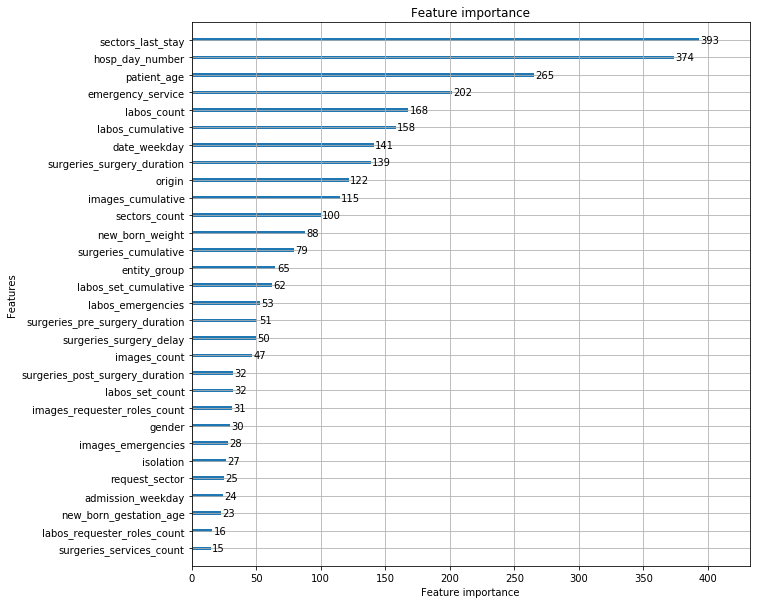

In [42]:
lgb.plot_importance(bst, figsize=(10,10),max_num_features=30, importance_type='split')

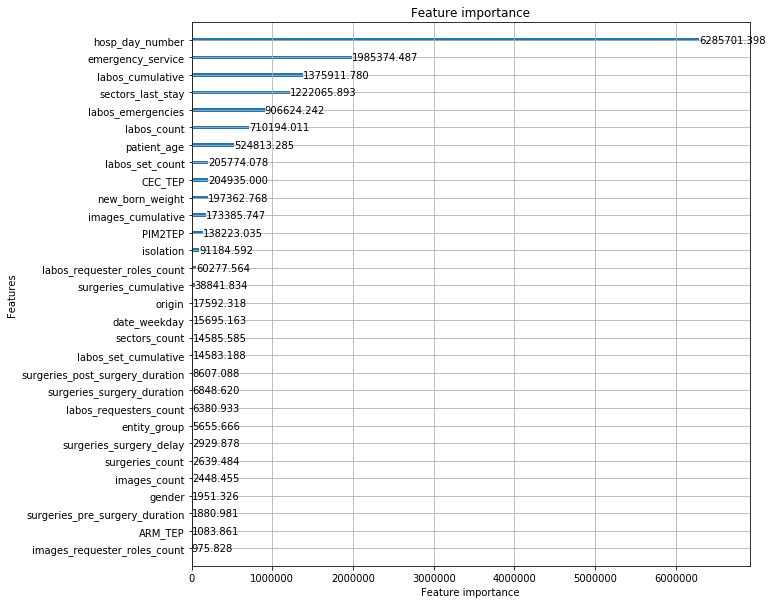

In [43]:
lgb.plot_importance(bst, figsize=(10,10),max_num_features=30, importance_type='gain')